In [197]:
from math import exp
import numpy as np

from sklearn import datasets
import pandas

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score 

from matplotlib import pyplot

from seaborn import pairplot

In [198]:
class NeuralNetwork:
    def __init__(self, layers_sizes : list[int]):
        self.layers_count = len(layers_sizes)
        self.weights = []
        self.biases = []
        self.__input_size__ = layers_sizes[0]
        self.__output_size__ = layers_sizes[-1]

        for i in range(len(layers_sizes) - 1):
            current_layer_size = layers_sizes[i]
            next_layer_size = layers_sizes[i + 1]

            
            layer_weights = np.random.randn(current_layer_size, next_layer_size)
            #layer_weights = np.random.choice(range(-5, 5), size=(current_layer_size, next_layer_size))
            layer_biases = np.zeros(next_layer_size)

            self.weights.append(layer_weights)
            self.biases.append(layer_biases)

    def activation_function(x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def activation_function_derivative(x):
        x = np.clip(x, -500, 500)
        return x * (1 - x)


    def calculate_neurons_outputs(self, x : list):
        if(len(x) != self.__input_size__):
            raise ValueError()
        activations = [np.array(x)]
        values = []
        for i in range(self.layers_count - 1):
            weights = self.weights[i]
            biases = self.biases[i]
            summs = np.dot(activations[-1], weights) + biases
            values.append(summs)
            activations.append(NeuralNetwork.activation_function(summs))
    
        return activations, values


    def predict(self, x : list) -> list[float]:
        return self.calculate_neurons_outputs(x)[0][-1]

    def backpropagation(self, x : list, y : list[float], learning_rate : float):
        x = np.array(x)
        y = np.array(y)
        
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]

        activations_values, neurons_values = self.calculate_neurons_outputs(x)

        delta = (activations_values[-1] - y) * NeuralNetwork.activation_function_derivative(activations_values[-1])

        delta_w[-1] = np.outer(activations_values[-2], delta)
        delta_b[-1] = delta

        for l in range(2, self.layers_count):
            z = neurons_values[-l]
            sp = NeuralNetwork.activation_function_derivative(activations_values[-l])

            delta = np.dot(self.weights[-l + 1], delta) * sp
            delta_w[-l] = np.outer(activations_values[-l - 1], delta)
            delta_b[-l] = delta

        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * delta_w[i]
            self.biases[i] -= learning_rate * delta_b[i]

    def fit(self, X : list[list], Y : list[list[float]], epochs : int = 1000 , learning_rate : float = 0.01):
        for _ in range(epochs):
            entries_count = len(X)
            for i in range(entries_count):
                x = X[i]
                y = Y[i]
                
                self.backpropagation(x, y, learning_rate)



In [199]:
class NNClassifier:
    def __init__(self, input_size : int, hidden_layers_sizes : list[int] , classes):
        self.input_size = input_size
        self.classes = list(set(classes)) # to allow getting items indices 
        self.inner_nn = NeuralNetwork(layers_sizes= [input_size] + hidden_layers_sizes + [len(self.classes)])

    def fit(self, X : list[list], Y : list, epochs : int = 1000 , learning_rate : float = 0.01):
        y_outputs = []
        for target_class in Y:
            target_class_index = self.classes.index(target_class)
            y_output = [0 for _ in range(len(self.classes))]
            y_output[target_class_index] = 1

            y_outputs.append(y_output)
        
        self.inner_nn.fit(X, y_outputs, epochs, learning_rate)

    def predict(self, x : list):
        result_index = np.argmax(self.inner_nn.predict(x))
        
        return self.classes[result_index].astype(object)




In [200]:
iris = datasets.load_iris()

X = pandas.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [201]:
def draw_boundaries(model : NNClassifier, initial_data : pandas.DataFrame):
    # Dividing lines is not possible because amount of features is four and instead of lines it should be 3 dimensional hyperplanes
    predicted = []
    for x in initial_data.values:
        predicted.append(model.predict(x))

    dataframe = initial_data.copy(False)
    dataframe.insert(0, 'class', predicted)
    pairplot(dataframe, hue='class')
    

Precision: 0.9629629629629629
Recall: 0.9722222222222222


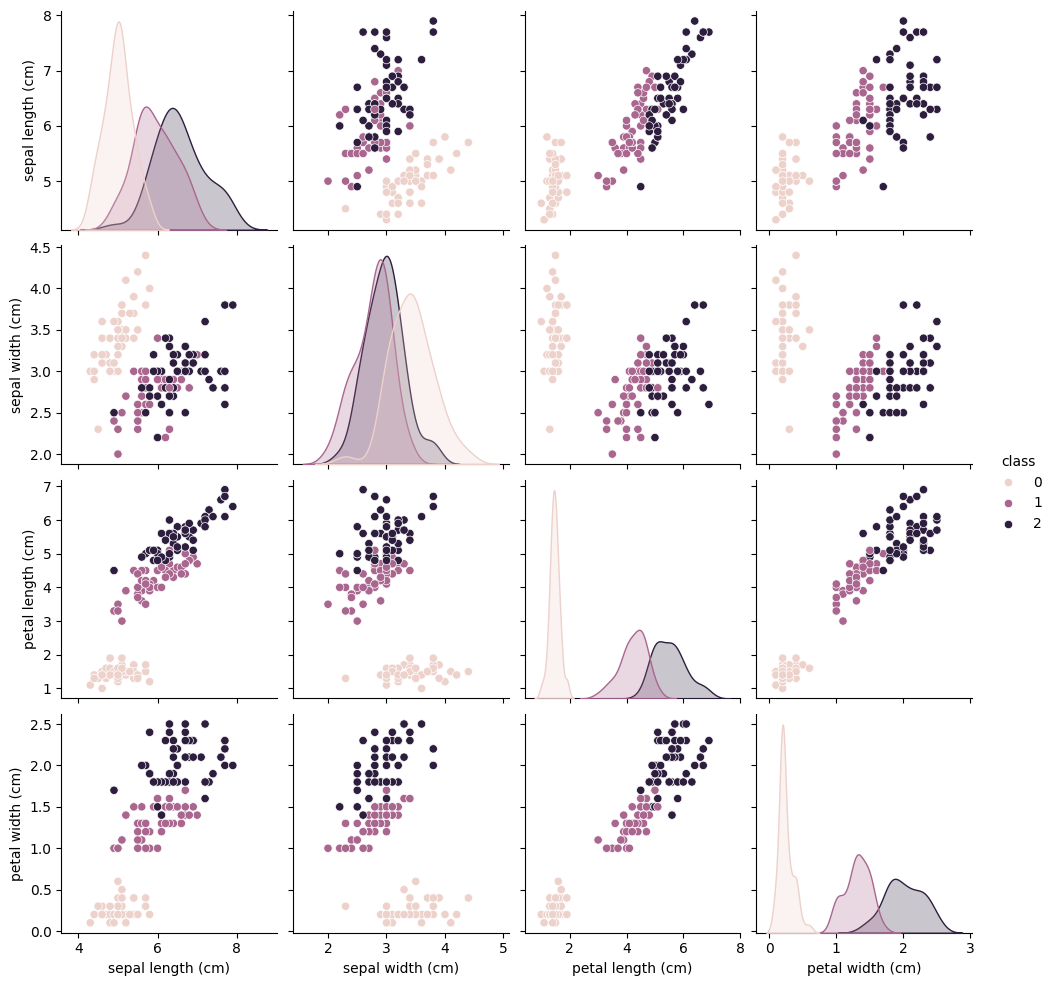

In [202]:
nn = NNClassifier(4, [10, 10], y)
nn.fit(X_train.values, y_train, epochs = 1000)

predicted = []
for x in X_test.values:
    predicted.append(nn.predict(x))
precision = precision_score(y_test, predicted, average = 'macro')
recall = recall_score(y_test, predicted, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)

draw_boundaries(nn, X)

c:\Users\yaggod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4666666666666666
Recall: 0.6666666666666666


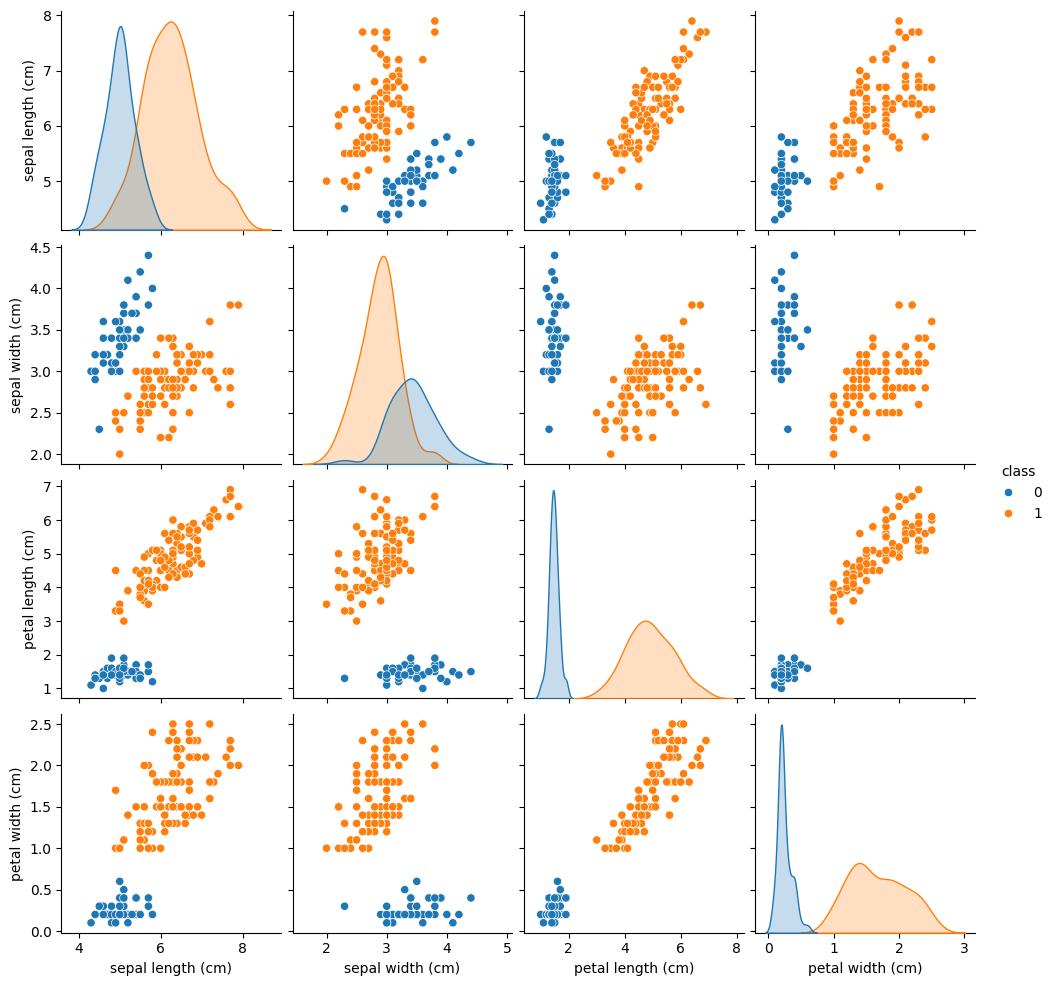

In [207]:
nn = NNClassifier(4, [1], y)
nn.fit(X_train.values, y_train, epochs = 2000)

predicted = []
for x in X_test.values:
    predicted.append(nn.predict(x))

precision = precision_score(y_test, predicted, average = 'macro')
recall = recall_score(y_test, predicted, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)

draw_boundaries(nn, X)